In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# dev environment

In [3]:


# define the base path
path = '/michorlab/manuel/data/in_silico_parameter/'


# load csv file
results_df = pd.read_csv(path+f'results_correlation.csv')
results_df.shape

(270, 6)

In [4]:
results_df

,name,mod,param,dataset,split,correlation
0,SETTING1_std,Linear Regression,alpha,Train,0,0.970713
1,SETTING1_std,Linear Regression,alpha,Train,1,0.970029
2,SETTING1_std,Linear Regression,alpha,Train,2,0.968841
3,SETTING1_std,Linear Regression,alpha,Train,3,0.966730
4,SETTING1_std,Linear Regression,alpha,Train,4,0.969693
...,...,...,...,...,...,...
265,SETTING3_4gy,PFN,a+2b,Test,0,0.241355
266,SETTING3_4gy,PFN,a+2b,Test,1,0.241075
267,SETTING3_4gy,PFN,a+2b,Test,2,0.370664
268,SETTING3_4gy,PFN,a+2b,Test,3,0.258262


In [5]:
# rename param into parameter
results_df = results_df.rename(columns={'param':'parameter', 'mod':'model'})

In [6]:
# rename models
dict_rename = {'Linear Regression': 'Sparse Linear Regression', 'Random Forest': 'Random Forest', 'PFN': 'Transformer'}
results_df['model'] = results_df['model'].map(dict_rename)

In [7]:
# make new column for short names based on the mapping dictionary
dicts = { 'SETTING1_std': 'standard', 'SETTING2_opt': 'optimal', 'SETTING3_4gy': 'suboptimal' }
results_df['name_short'] = results_df['name'].map(dicts)

In [8]:
# rename parameter 'a+2b' into 'cell speed'
name_new_cell_speed = 'cell speed'
results_df['parameter'] = results_df['parameter'].replace('a+2b', name_new_cell_speed)

In [9]:
# make new column by concat name_short and parameter
results_df['name_short_param'] =  results_df['parameter']+', ' +results_df['name_short']

In [10]:
results_df['name'].unique()

array(['SETTING1_std', 'SETTING2_opt', 'SETTING3_4gy'], dtype=object)

In [11]:
# renamae name_short_param
results_df = results_df.rename(columns={'name_short_param':'parameter & schedule', 'correlation':'correlation (true/predicted)'})

In [12]:
results_df['parameter'].unique()

array(['alpha', 'beta', 'cell speed'], dtype=object)

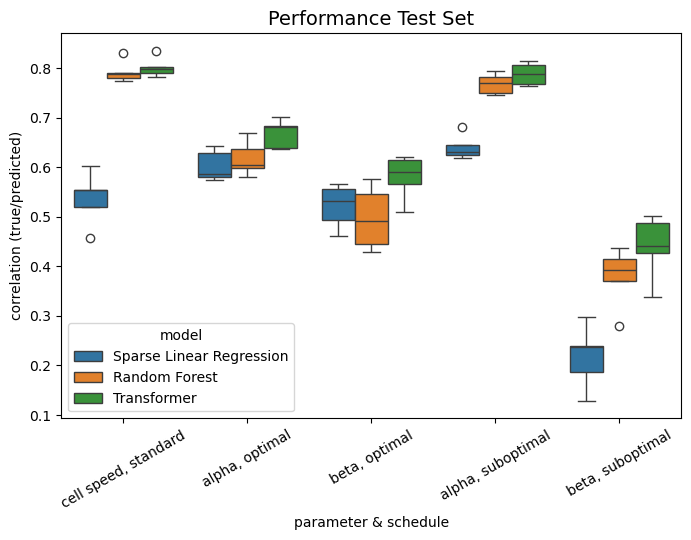

In [13]:
# filter only for test
inds_test = results_df['dataset'] == 'Test'

inds_alpha = (results_df['parameter'] == 'alpha') & ((results_df['name_short']=='optimal') | (results_df['name_short']=='suboptimal') )
inds_beta = (results_df['parameter'] == 'beta') & ((results_df['name_short']=='optimal') | (results_df['name_short']=='suboptimal') )
inds_speed = (results_df['parameter'] == name_new_cell_speed) & (results_df['name_short']=='standard')  

inds_take = inds_test & (inds_alpha | inds_beta | inds_speed)

df_subset = results_df[inds_take]

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_subset, x="parameter & schedule", y="correlation (true/predicted)", hue="model")
plt.xticks(rotation=30)
plt.title("Performance Test Set", fontsize=14)

# save figure
plt.savefig( path+f'figures' + f'/ML_comparison.pdf', dpi=300, bbox_inches='tight')

plt.show()

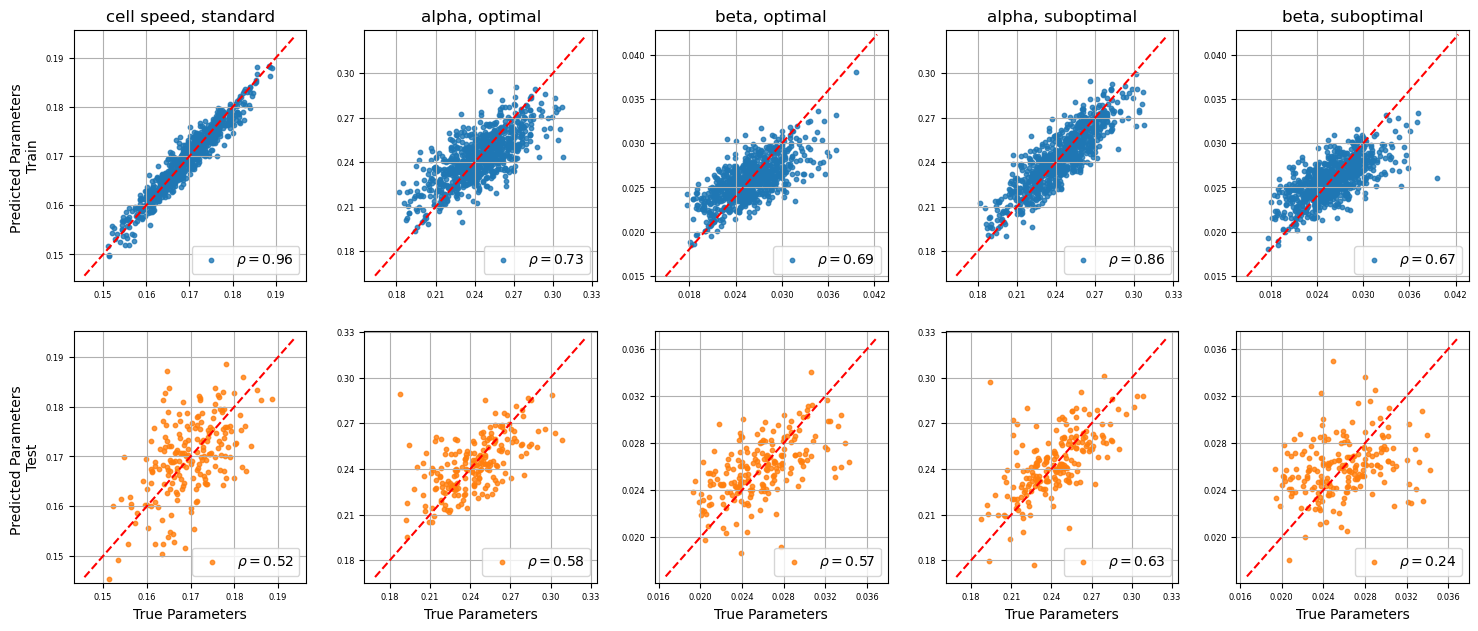

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MaxNLocator



# define the base path
path = '/michorlab/manuel/data/in_silico_parameter/'


modName = 'PFN' #['Linear Regression', 'Random Forest', 'PFN']:
modName =  'Random Forest'
modName = 'Linear Regression'

param_name = [ ('a+2b','SETTING1_std', name_new_cell_speed+', standard'), 
              ('alpha','SETTING2_opt', 'alpha, optimal'), ('beta','SETTING2_opt', 'beta, optimal'), 
              ('alpha','SETTING3_4gy', 'alpha, suboptimal'), ('beta','SETTING3_4gy','beta, suboptimal')]

spltNR = 0


# Create a figure with 2 rows (train/test) and 4 columns (one for each param)
fig, axes = plt.subplots(2, len(param_name), figsize=(18, 7), subplot_kw={'sharex': col} ) 
                        #constrained_layout=True)


if modName == 'PFN':
    modName_write = 'Transformer'
else:
    modName_write = modName
# fig.suptitle(f'True vs Predicted Values with {modName_write}', fontsize=16)
    
    
for col, (param,name,write_name) in enumerate(param_name):

    load_name_results = f'results_{name}.pkl'

    # load the results again
    with open(path+load_name_results, 'rb') as f:
        all_results = pickle.load(f)

    
    for row, dataset_type in enumerate(['Train', 'Test']):
        # Construct the case_name string
        case_name = f'{param}_{modName}_split_{spltNR}'
        
        # Select appropriate data based on train/test
        if dataset_type == 'Train':
            y = all_results[case_name]['Y_train']
            pred = all_results[case_name]['train_pred']
        else:  # Test
            y = all_results[case_name]['Y_test']
            pred = all_results[case_name]['test_pred']
        
        # Compute correlation
        corr = np.corrcoef(y, pred)[0, 1]  # Pearson correlation
        
        # Select the corresponding subplot
        ax = axes[row, col]
        
        # Plot the scatter plot
        # ax.scatter(y, pred, label=f"Predictions ({dataset_type})", color='C0' if dataset_type == 'Train' else 'C1', s=10, alpha=0.8)
        ax.scatter(y, pred, label=r"$\rho=$"+f"{corr:.2f}", color='C0' if dataset_type == 'Train' else 'C1', s=10, alpha=0.8)
        
        # Plot the perfect prediction line (y = x) with margin
        margin = np.std(y)*0.8
        ax.plot(
            [min(y) - margin, max(y) + margin],
            [min(y) - margin, max(y) + margin],
            color='red', linestyle='--' #, label="Perfect Prediction Line"
        )
        
        ax.set_ylim(min(y) - 1.2*margin, max(y) + 1.2*margin)
        
        # Set title, labels, and grid
        # ax.set_title(f'{write_name}, {dataset_type}, corr={corr:.2f}', fontsize=12)
        # ax.set_title(f'{write_name}, corr={corr:.2f}', fontsize=12)
        if row == 0:
            ax.set_title(f'{write_name}', fontsize=12)
        
        if row == 1:
            # ax.set_xlabel(f'{write_name}\n True Parameters')
            ax.set_xlabel(f'True Parameters')
        
        if col == 0:
            ax.set_ylabel(f'Predicted Parameters \n{dataset_type}')
        ax.legend(loc='lower right')
        ax.grid(True)
        
        ax.tick_params(axis='x', labelsize=6) 
        ax.tick_params(axis='y', labelsize=6) 
        
        
        # formatter = FuncFormatter(lambda y, _: f"{y:.2f}")
        # ax.yaxis.set_major_formatter(formatter) 
        
        # formatter = FuncFormatter(lambda x, _: f"{x:.2f}")
        # ax.xaxis.set_major_formatter(formatter) 
        
        ax.xaxis.set_major_locator(MaxNLocator(nbins=6))  # Max 5 ticks on the x-axis
        ax.yaxis.set_major_locator(MaxNLocator(nbins=6))  # Max 5 ticks on the x-axis


    
    # Show the final figure
plt.subplots_adjust(top=0.9, hspace=.2, wspace=.25)
plt.show()

# save the figure
fig.savefig( path+f'figures' + f'/true_vs_pred_{modName}.pdf', dpi=300, bbox_inches='tight')
    
    



Saving figure: /michorlab/manuel/data/in_silico_parameter/figures/Linear Regression_SETTING3_4gy_true_vs_pred.png


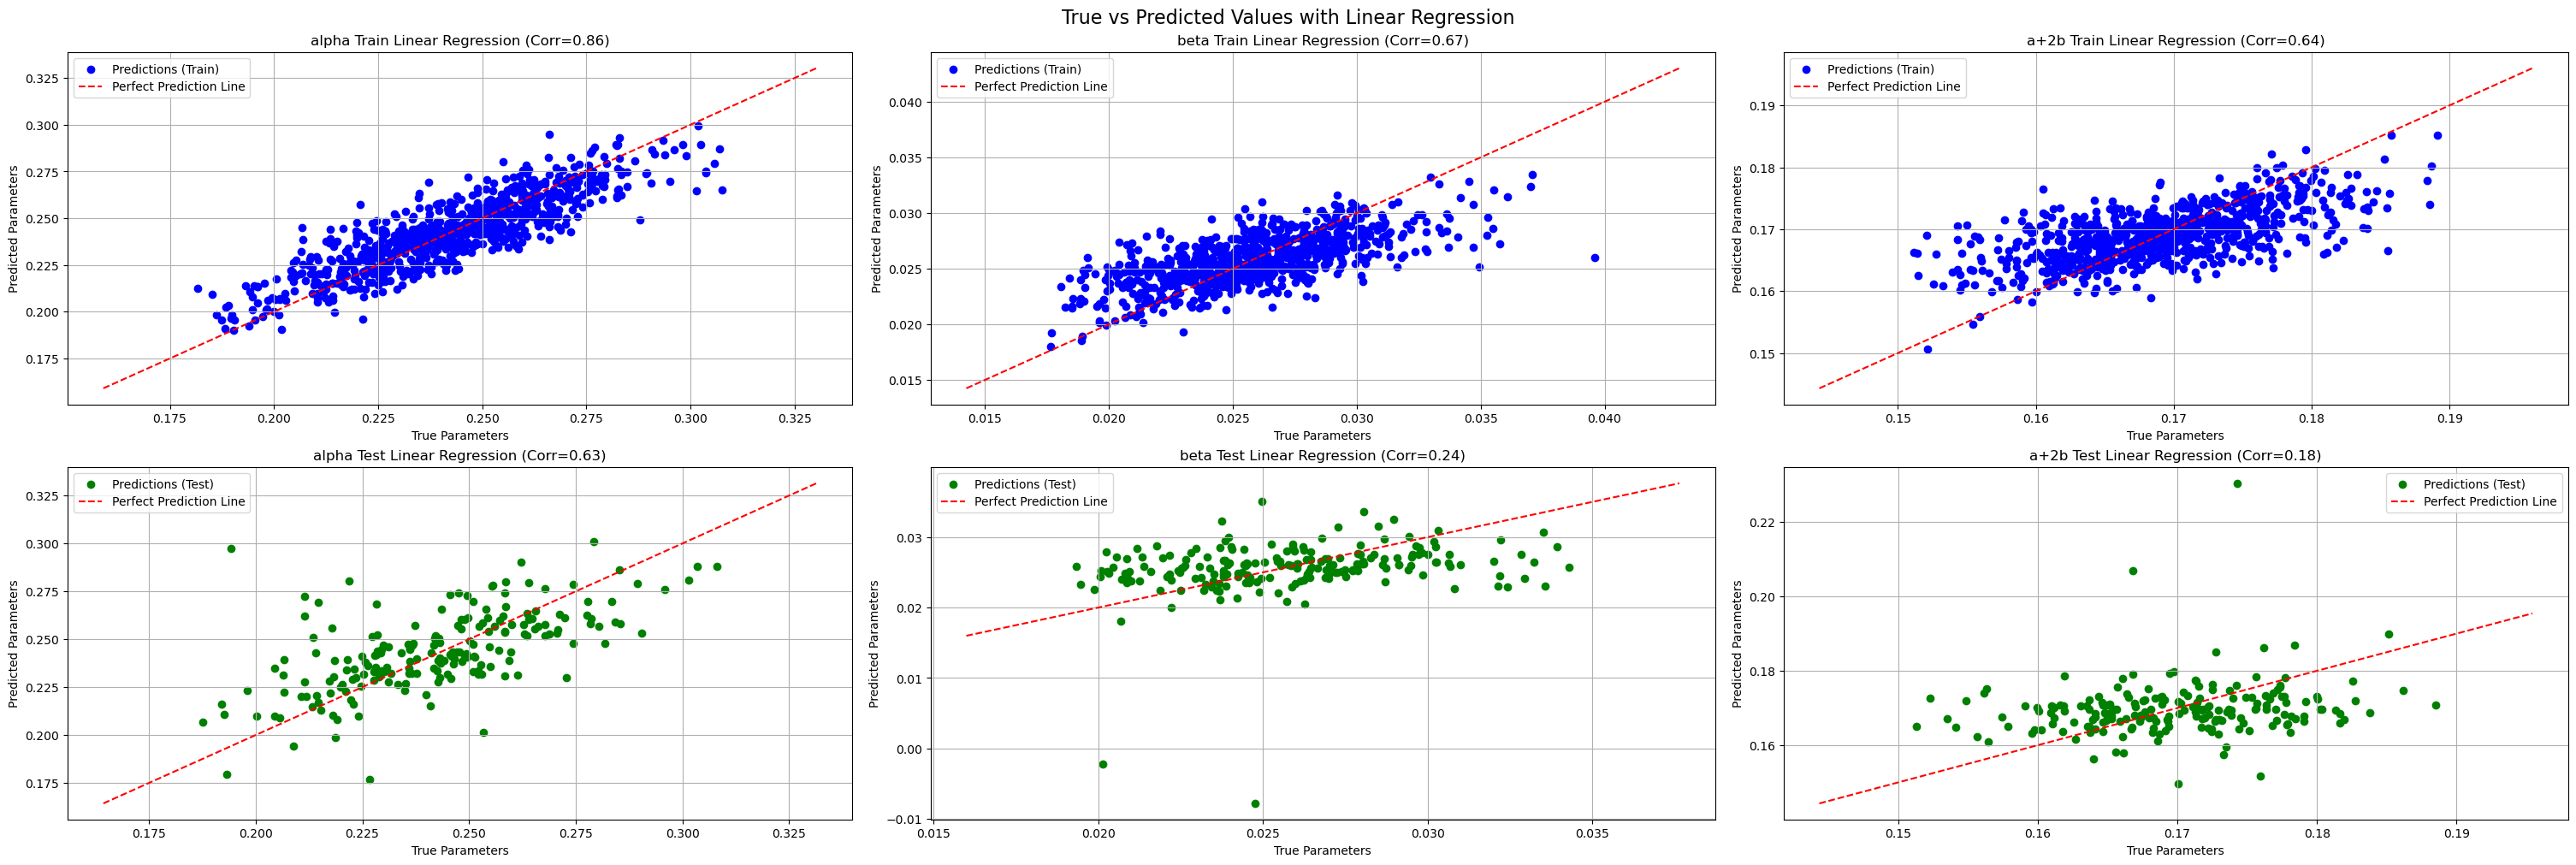

Saving figure: /michorlab/manuel/data/in_silico_parameter/figures/Random Forest_SETTING3_4gy_true_vs_pred.png


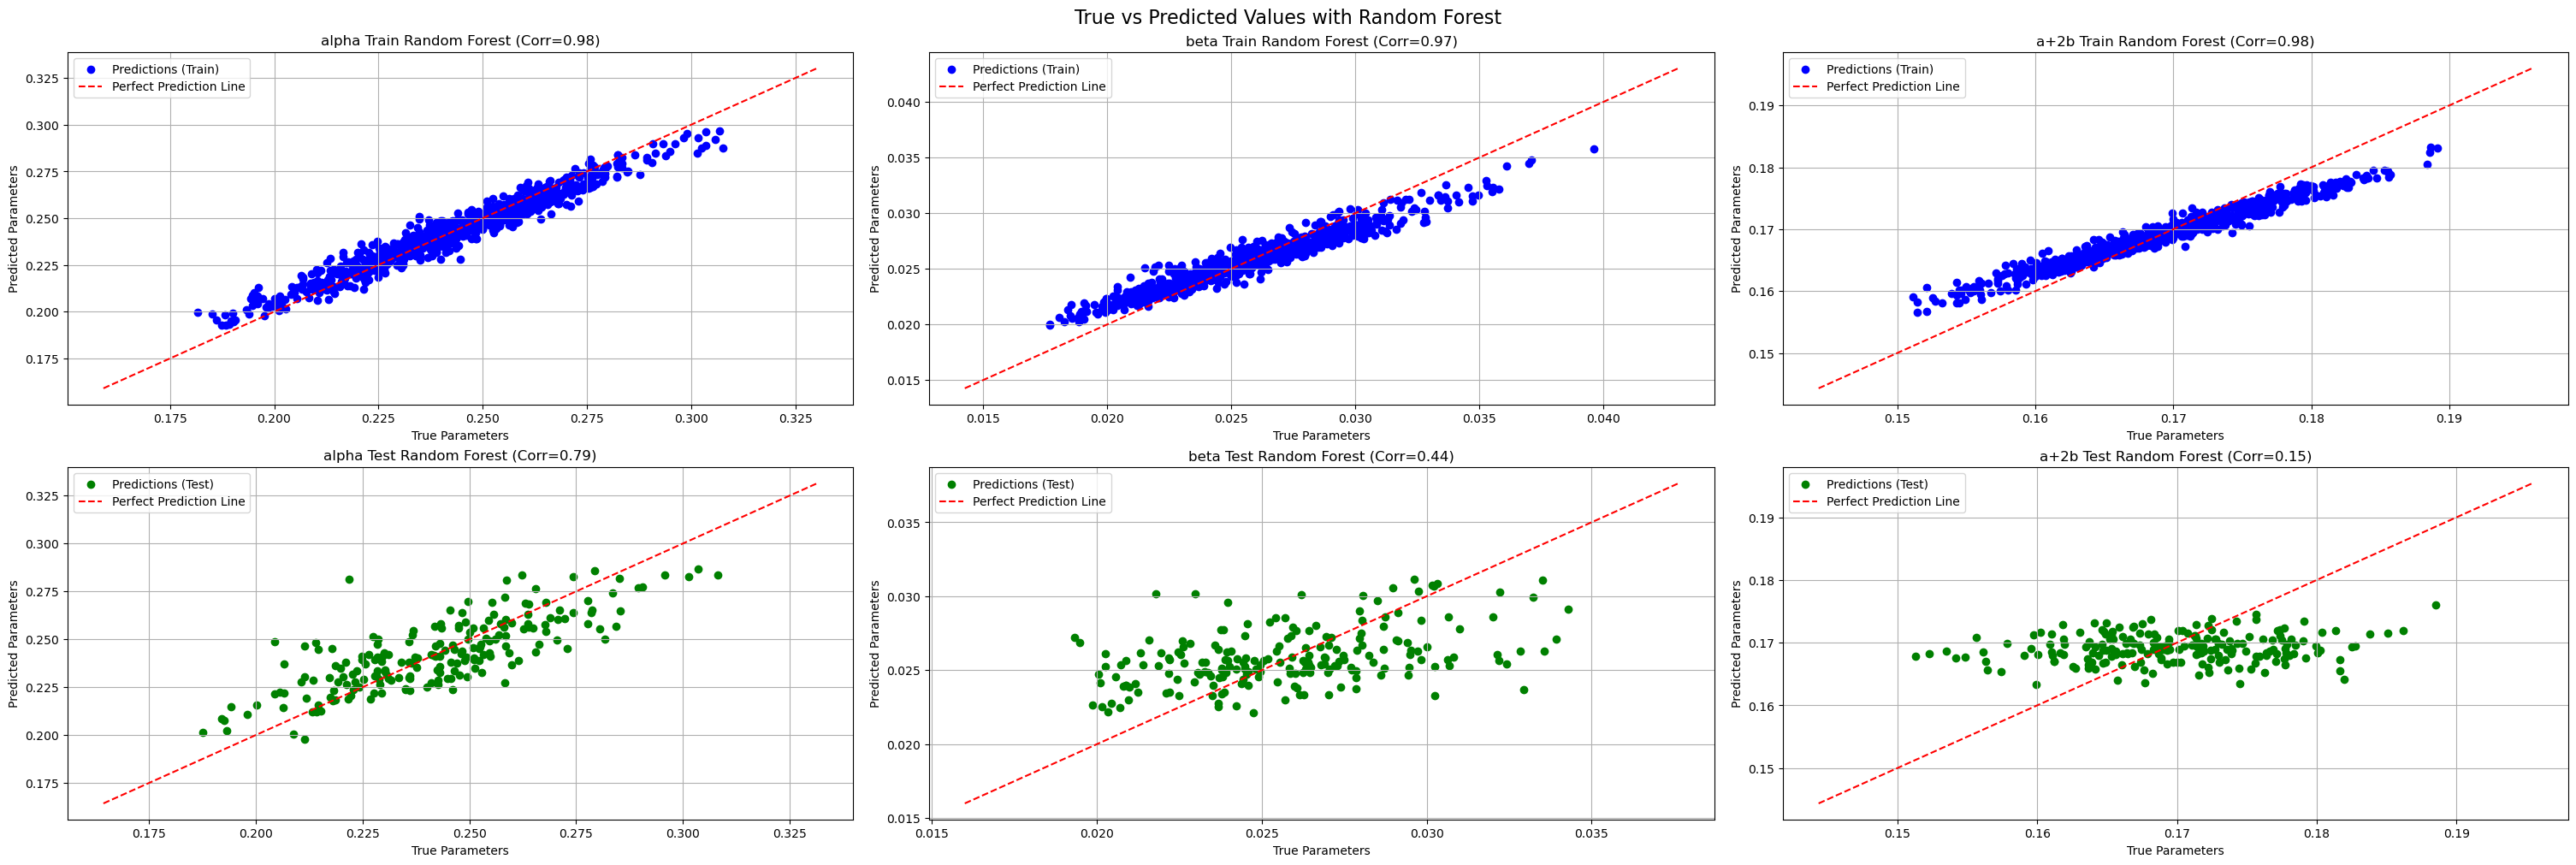

Saving figure: /michorlab/manuel/data/in_silico_parameter/figures/PFN_SETTING3_4gy_true_vs_pred.png


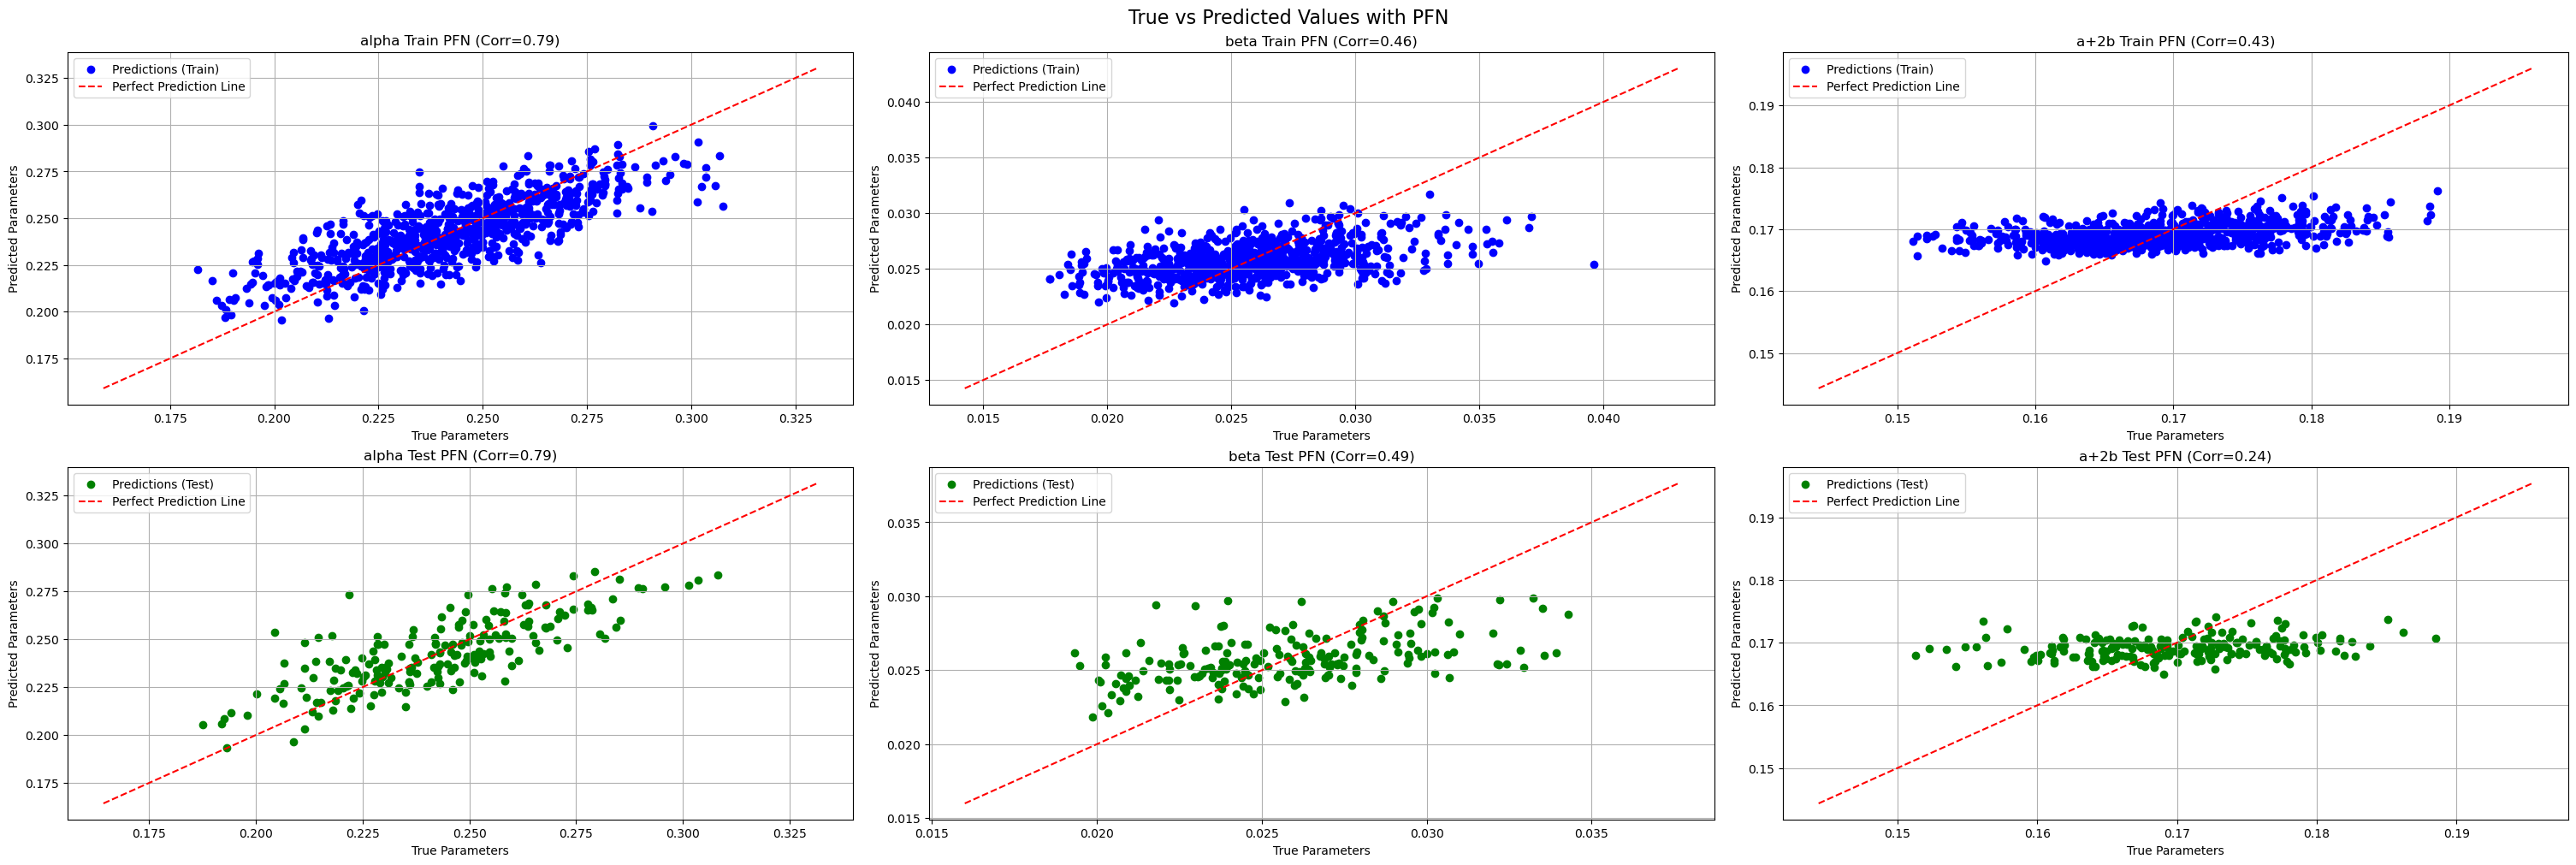

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import pickle



# define the base path
path = '/michorlab/manuel/data/in_silico_parameter/'


## setting 
name = 'SETTING1_std' 
name = 'SETTING2_opt'
name = 'SETTING3_4gy'


spltNR = 0


load_name_results = f'results_{name}.pkl'

# load the results again
with open(path+load_name_results, 'rb') as f:
    all_results = pickle.load(f)


for modName in ['Linear Regression', 'Random Forest', 'PFN']:


    # List of parameters to loop through
    # params_list = ['alpha', 'beta', 'a', 'b']
    # params_list = ['alpha', 'beta', 'a', 'b', 'alpha/beta', 'a/b', 'alpha+beta', 'a+b']
    # params_list = list(params.columns)
    params_list = ['alpha', 'beta', 'a+2b']

    # Create a figure with 2 rows (train/test) and 4 columns (one for each param)
    fig, axes = plt.subplots(2, len(params_list), figsize=(30, 10), 
                            constrained_layout=True)
    fig.suptitle(f'True vs Predicted Values with {modName}', fontsize=16)

    # Loop through parameters and train/test
    for col, param in enumerate(params_list):
        for row, dataset_type in enumerate(['Train', 'Test']):
            # Construct the case_name string
            case_name = f'{param}_{modName}_split_{spltNR}'
            
            # Select appropriate data based on train/test
            if dataset_type == 'Train':
                y = all_results[case_name]['Y_train']
                pred = all_results[case_name]['train_pred']
            else:  # Test
                y = all_results[case_name]['Y_test']
                pred = all_results[case_name]['test_pred']
            
            # Compute correlation
            corr = np.corrcoef(y, pred)[0, 1]  # Pearson correlation
            
            # Select the corresponding subplot
            ax = axes[row, col]
            
            # Plot the scatter plot
            ax.scatter(y, pred, label=f"Predictions ({dataset_type})", color='blue' if dataset_type == 'Train' else 'green')
            
            # Plot the perfect prediction line (y = x) with margin
            margin = np.std(y)
            ax.plot(
                [min(y) - margin, max(y) + margin],
                [min(y) - margin, max(y) + margin],
                color='red', linestyle='--', label="Perfect Prediction Line"
            )
            
            # Set title, labels, and grid
            ax.set_title(f'{param} {dataset_type} {modName} (Corr={corr:.2f})')
            ax.set_xlabel('True Parameters')
            ax.set_ylabel('Predicted Parameters')
            ax.legend()
            ax.grid(True)

    # save the figure
    print(f"Saving figure: {path+f'figures/{modName}_{name}_true_vs_pred.png'}")
    fig.savefig(path+f'figures/{modName}_{name}_true_vs_pred.png')
    
    # Show the final figure
    plt.show()
    
    

